## Task 4 - Topic Modelling using LDA

Exploring Topic Modelling using the Latent Dirichlet Allocation Topic Modeller using the Gensim library.

__References__
* Gensim [documentation](https://radimrehurek.com/gensim/models/ldamodel.html)
* TowardsDataScience [blogpost](https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835)


Assumptions:
* __URLs__ would be removed
* __Hashtags__ would be removed
* __Mentions__ would be removed
* __Repeating dots__ (more than two occurences) e.g.: __...__ would be removed
* __Emojis__ would be removed
* __Repeating characters__ (more than two occurences) e.g.: عاااااااجل would be removed
* __Arabic Diacritics__ would be removed
* __Punctuation__ would be removed (only alphanumeric characters)
* __Lemmatization__ would be performed using the Qalsadi lemmatizer

__Stopwords__ would need to be removed in a future step

In [1]:
import pandas as pd
import emoji  # for removing emojis
import pyarabic.araby as araby  # for removing diacritics
import math
import re
import os
import qalsadi.lemmatizer
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pyLDAvis  # For visualizing LDA topics
import pyLDAvis.gensim_models as gensimvis  
from tqdm import tqdm
from camel_tools.tokenizers.word import simple_word_tokenize
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
# For checking appropriate format for LDA Model
from gensim.test.utils import common_corpus, common_texts

/home/tamer/anaconda3/envs/psut-nlp-project/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
qalsadi_lemmatizer = qalsadi.lemmatizer.Lemmatizer()

In [3]:
# From Task1
def clean(sentence):
    """Pre-processes an Arabic sentence for bigram modelling.

    1- Removes URLs, Hashtags, Mentions, and repeating dots.
    2- Removes repeating characters than occur more than twice.
    3- Removes emojis.
    4- Removes Arabic Diacritics.
    5- Removes punctuations and only keeps alphanumeric characters.
    6- Converts sentence to Word Tokens.
    7- Lemmatizes each Token using the Qalsadi Lemmatizer.

    Args:
        sentence (string): Arabic sentence to preprocess.

    Returns:
        sequence (list): processed list of tokens. 
    """
    def _remove_emojis(string):
        return emoji.get_emoji_regexp().sub(u"", string)

    def _remove_diacritics(string):
        return araby.strip_diacritics(string)

    re_general_pattern = r"https?:\/\/.*[\r\n]*|#\w+|@\w+|\.{2,}"
    re_repeating_character_pattern = r"(\w)\1{2,}"

    # 1- Removing URLs, Hashtags, Mentions, and repeating dots
    sentence = re.sub(re_general_pattern, "", sentence)
    # 2- Removing repeating characters that occur more than twice
    sentence = re.sub(re_repeating_character_pattern, r"\1", sentence)
    # 3- Removing emojis
    sentence = _remove_emojis(sentence)
    # 4- Removing arabic diacritics
    sentence = _remove_diacritics(sentence)
    # 5- Tokenization and punctuation removal (only alphanumeric)
    sequence = [token.lower() for token in simple_word_tokenize(sentence) if token.isalpha()]
    # 6- Lemmatization
    sequence = [qalsadi_lemmatizer.lemmatize(token) for token in sequence]

    return sequence

In [4]:
common_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

In [5]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [6]:
Dictionary(common_texts)

In [7]:
dir(Dictionary)

['__abstractmethods__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_adapt_by_suffix',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'add_documents',
 'add_lifecycle_event',
 'compactify',
 'doc2bow',
 'doc2idx',
 'filter_extremes',
 'filter_n_most_frequent',
 'filter_tokens',
 'from_corpus',
 'from_documents',
 'get',
 'items',
 'iteritems',
 'iterkeys',
 'itervalues',
 'keys',
 'load',
 'load_from_text',
 'merge_with',
 'most_common',
 'patch_with_special_tokens',
 'save',
 'save_as_text',
 'values']

### 1- Importing and cleaning the 50,000 arabic tweets data

In [8]:
data_df = pd.read_csv("data/full_data.txt", sep="\t")
data_df.drop("tweetID", axis=1, inplace=True)

In [9]:
data_df

,tweetText
0,حال استنفار قصوى في شمال فرنسا http://t.co/umT...
1,عَمْرُو عبد الهادي الاعلام الصهيوني المصري مش ...
2,عرض فرصه للبيع مزرعه من الوكيل مباشر في الدائر...
3,10 قتلى بانفجارين أحدهما بمسجد شيعي في بغداد h...
4,@teriangle_hd القنابل البدائية مش من مقام فرنس...
...,...
49995,السيادة على مزارع شبعا http://t.co/LaUZcJYZii ...
49996,"#عاجل أوامر ملكية بعد قليل على السعودية الأولى"""
49997,عاجل/ أوامر ملكية بعد قليل على قناة السعودية ا...
49998,#الرياض الميليشيات تبايع نوري المالكي!: الميلي...


In [10]:
# Cleaning texts and appending to texts list
tweets_list = []

for index, tweet in tqdm(data_df.iterrows()):
    tweet = clean(tweet[0])
    tweets_list.append(tweet)

50000it [18:46, 44.40it/s]


In [11]:
tweets_list[0]

['حال', 'استنفار', 'قصوى', 'في', 'شمال', 'فرنسا']

In [12]:
len(tweets_list)

50000

### 2- Preparing the tweets for LDA Topic Modelling

In [13]:
tweet_dictionary = Dictionary(tweets_list)

In [14]:
tweet_dictionary

In [15]:
tweet_corpus = [tweet_dictionary.doc2bow(tweet) for tweet in tweets_list]

In [16]:
tweet_corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

### 3- LDA Topic Modelling

#### 3.1 Calculating coherence scores for multiple LDA models
Reference [blogpost](https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835)

In [17]:
RANDOM_STATE = 420

In [18]:
# compute coherence
tweets_coherence = []

for nb_topics in tqdm(range(1, 51)):
    lda_model = LdaMulticore(
        random_state=RANDOM_STATE,
        corpus=tweet_corpus,
        num_topics=nb_topics,
        id2word=tweet_dictionary,
        workers=os.cpu_count(),  # Number of available CPU cores
        chunksize=300,  # Assuming looking at 300 tweets per training step is better than the default 2000
        passes=5,
        alpha='symmetric',
        decay=0.5,
        offset=1.0,
        eval_every=10,
        gamma_threshold=0.001
    )
    cohm = CoherenceModel(model=lda_model, corpus=tweet_corpus, dictionary=tweet_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:53<00:00, 10.67s/it]


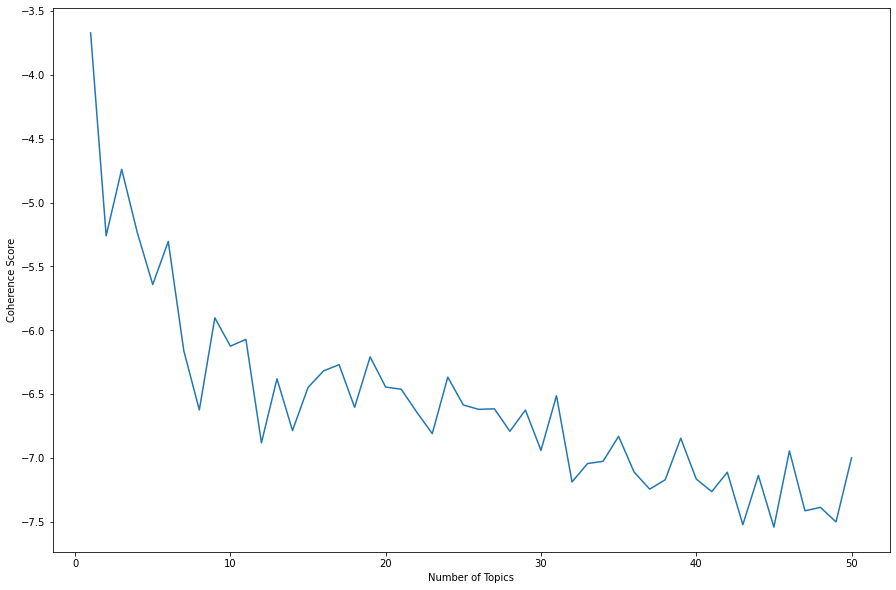

In [19]:
# visualize coherence
plt.figure(figsize=(15, 10))
plt.plot(range(1, 51), tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

In [20]:
tweets_coherence

[-3.6717510372711284,
 -5.259899766017124,
 -4.73942898994452,
 -5.232093659974636,
 -5.641537144913976,
 -5.30416231813079,
 -6.159212192749502,
 -6.623003847610665,
 -5.901968070569417,
 -6.12392204803784,
 -6.0707440747144545,
 -6.880684924966039,
 -6.379431153256159,
 -6.7840983018832,
 -6.447366978901436,
 -6.317452662874761,
 -6.268779201649829,
 -6.602450464578778,
 -6.207949282600118,
 -6.444086103362189,
 -6.460821095450096,
 -6.63993861260851,
 -6.808510882157227,
 -6.366217840796668,
 -6.584375558136856,
 -6.618684672356991,
 -6.61421961054159,
 -6.790089872311568,
 -6.623684537597927,
 -6.939648315321981,
 -6.511947721834708,
 -7.186656343105964,
 -7.04267729507095,
 -7.0253306531174555,
 -6.829759176833884,
 -7.1098477127063715,
 -7.242838331121178,
 -7.169966755623984,
 -6.844484915922065,
 -7.163824199484705,
 -7.262500262441675,
 -7.110629695952497,
 -7.521182379848949,
 -7.135777598164043,
 -7.54012013649652,
 -6.943480754014287,
 -7.412445585681853,
 -7.38574889722103

### Choosing number of topics = 6
Highest cohesive score point at point 6 before lower coherence scores afterwards (assumption may be incorrect)

__Notes__
* Tweets are not the most optimal corpus for coherence score calculation which explains zigzag patterns in the plot
* Need to check the [stLDA-C](https://github.com/g-tierney/stLDA-C_public) implementation for future experiments regarding LDA models that are more suitable to tweet-sized documents.

#### 3.2 LDA modeling

In [21]:
NUM_TOPICS = 6

lda_model = LdaMulticore(
    random_state=RANDOM_STATE,
    corpus=tweet_corpus,
    num_topics=NUM_TOPICS,
    id2word=tweet_dictionary,
    workers=os.cpu_count(),  # Number of available CPU cores
    chunksize=300,  # Assuming looking at 300 tweets per training step is better than the default 2000
    passes=5,
    alpha='symmetric',
    decay=0.5,
    offset=1.0,
    eval_every=10,
    gamma_threshold=0.001
)

In [22]:
lda_model

In [23]:
lda_model.show_topics()

[(0,
  '0.037*"في" + 0.018*"من" + 0.014*"دول" + 0.014*"عن" + 0.013*"كوباني" + 0.012*"رئيس" + 0.010*"بن" + 0.009*"الاسلامية" + 0.009*"على" + 0.009*"و"'),
 (1,
  '0.047*"على" + 0.034*"في" + 0.029*"هجوم" + 0.026*"مزارع" + 0.025*"بعد" + 0.024*"سعودي" + 0.022*"مقتل" + 0.017*"حرام" + 0.014*"شمال" + 0.014*"حدود"'),
 (2,
  '0.022*"يابان" + 0.020*"من" + 0.020*"في" + 0.018*"و" + 0.012*"مباراة" + 0.012*"منتخب" + 0.009*"على" + 0.009*"ما" + 0.009*"كل" + 0.008*"ملك"'),
 (3,
  '0.077*"في" + 0.033*"تفجير" + 0.021*"من" + 0.020*"يمن" + 0.014*"انتحار" + 0.012*"شرطة" + 0.010*"صنعاء" + 0.010*"مقتل" + 0.009*"انفجار" + 0.009*"قتلى"'),
 (4,
  '0.043*"في" + 0.028*"عراق" + 0.026*"الله" + 0.020*"حزب" + 0.018*"من" + 0.018*"رئيس" + 0.017*"جنوب" + 0.017*"كور" + 0.015*"يمن" + 0.014*"قياد"'),
 (5,
  '0.045*"على" + 0.043*"في" + 0.030*"هجوم" + 0.024*"شارل" + 0.022*"لبن" + 0.016*"من" + 0.015*"فندق" + 0.014*"سوري" + 0.014*"صحيفة" + 0.013*"دخول"')]

In [24]:
# Imported from:
#  https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835

def plot_top_words(lda=lda_model, nb_topics=NUM_TOPICS, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(NUM_TOPICS)) + 1, round(math.sqrt(NUM_TOPICS)) + 1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(25, 20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center', color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic " + str(i))
        

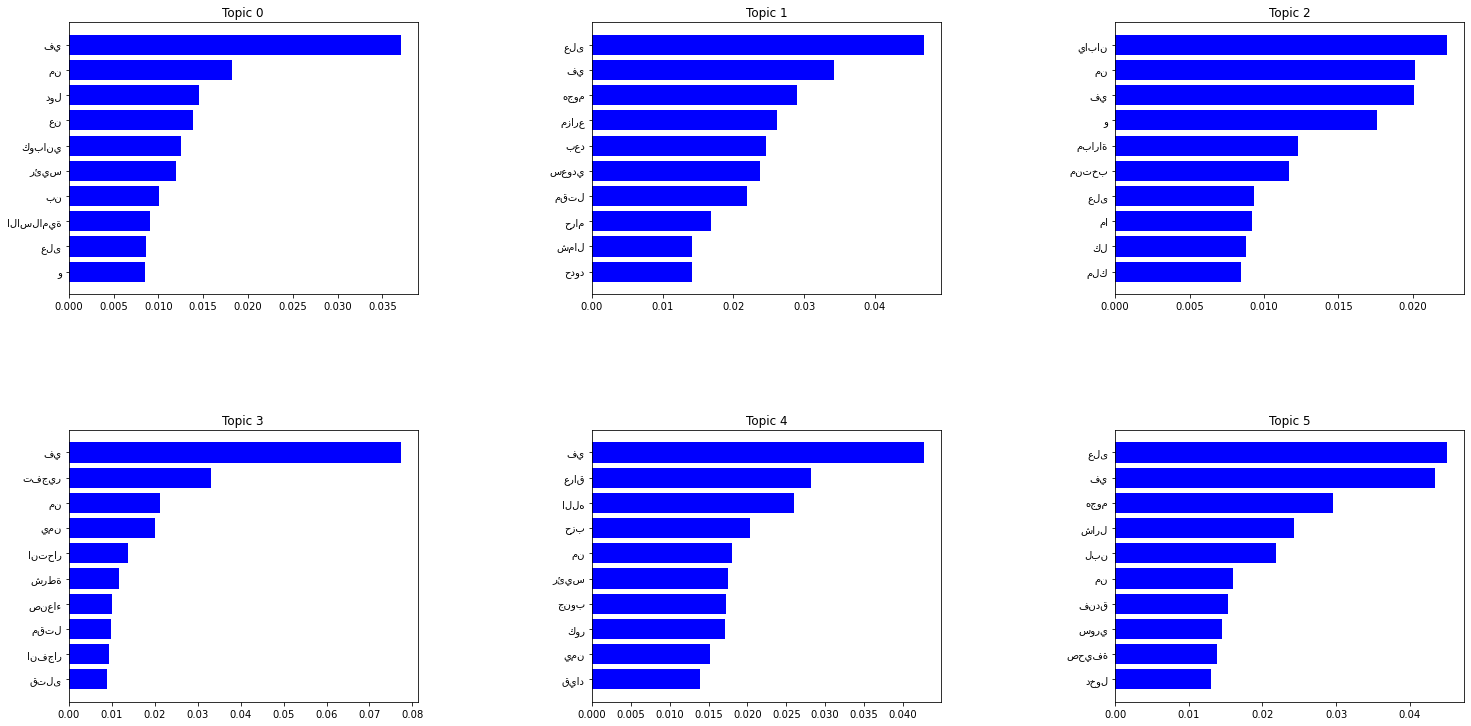

In [25]:
plot_top_words()

#### Trying pyLDAvis
Reference [blogpost](https://dzone.com/articles/topic-modelling-techniques-and-ai-models) [notebook](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=1&lambda=1&term=)

In [26]:
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model, tweet_corpus, tweet_dictionary)

/home/tamer/anaconda3/envs/psut-nlp-project/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.075886 -0.104986       1        1  21.990347
4      0.148996 -0.180298       2        1  17.804320
0      0.097818  0.049690       3        1  17.465285
5     -0.171825  0.070018       4        1  15.726185
2      0.159473  0.164514       5        1  14.442775
1     -0.158575  0.001062       6        1  12.571088, topic_info=       Term          Freq         Total Category  logprob  loglift
82     هجوم   5605.000000   5605.000000  Default  30.0000  30.0000
14      على  11707.000000  11707.000000  Default  29.0000  29.0000
48    تفجير   4971.000000   4971.000000  Default  28.0000  28.0000
2332  مزارع   1947.000000   1947.000000  Default  27.0000  27.0000
81     شارل   2330.000000   2330.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
512    داعش    478.780205   1135.634095   Topic6  -5.0485   1.2101
221      مع    644.778523   2630.405385   Topic6  -4.7509   0.6678
34       من    591.316480  10357.421024   Topic6  -4.8374  -0.7893
134    الله    503.669315   4305.867097   Topic6  -4.9979  -0.0720
55     عراق    403.954520   3636.036881   Topic6  -5.2185  -0.1236

[441 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
2069       1  0.014832     x
2069       5  0.978921     x
14084      4  0.016218  آشيا
14084      5  0.973099  آشيا
3081       1  0.007141   أبو
...      ...       ...   ...
233        2  0.086623   يوم
233        3  0.243409   يوم
233        4  0.133399   يوم
233        5  0.218289   يوم
233        6  0.073629   يوم

[1270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 6, 3, 2])

#### Stopwords would need to be removed in future steps